In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [9]:
df = pd.read_csv("data/cells.csv", delimiter=' ', header=None)

In [10]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def build_generator():
    #Initializing a neural network
    generator = Sequential()
    
    #Adding an Input layer to the network
    generator.add(Dense(units=256, input_dim=121))    

    #Activating the layer with LeakyReLU activation function
    generator.add(LeakyReLU(0.2))

    #Applying Batch Normalization 
    generator.add(BatchNormalization(momentum=0.8))

    #Adding a second layer	
    generator.add(Dense(units=512))
    
    #Adding a third layer	
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    #The output layer with 121(11x11) nodes
    generator.add(Dense(units=121, activation='tanh'))
    
    #Compiling the Generator Network with loss and optimizer functions
    generator.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=0.0002, beta_1=0.5))
    return generator

In [12]:
def build_discriminator():
    #Initializing a neural network
    discriminator=Sequential()
    
    #Adding an Input layer to the network
    discriminator.add(Dense(units=1024, input_dim= 121))
    
    #Activating the layer with LeakyReLU activation function
    discriminator.add(LeakyReLU(0.2))
    
    #Adding a dropout layer to reduce overfitting
    discriminator.add(Dropout(0.2))
       
    #Adding a second layer
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    #Adding a third layer	 
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    #Adding a forth layer
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #Adding the output layer with sigmoid activation
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #Compiling the Discriminator Network with loss and optimizer functions
    discriminator.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.0002, beta_1=0.5))

    return discriminator

In [13]:
def gan_net(generator, discriminator):
  
    #Setting the trainable parameter of discriminator to False
    discriminator.trainable=False
    
    #Instantiates a Keras tensor of shape 121 (Noise shape)
    inp = Input(shape=(121,))
    
    #Feeds the input noise to the generator and stores the output in X
    X = generator(inp)
    
    #Feeds the output from generator(X) to the discriminator and stores the result in out
    out= discriminator(X)
    
    #Creates a model include all layers required in the computation of out given inp.
    gan= Model(inputs=inp, outputs=out)
    
    #Compiling the GAN Network
    gan.compile(loss='binary_crossentropy', optimizer = 'adam',metrics=['acc', 'mse', 'mae'])
    
    return gan

In [14]:
def get_output(epoch, generator, dim = (11,11), figsize=(15,15)):
    #Generate a normally distributed noise of shape(11X11)
    noise= np.random.normal(loc=0, scale=1, size=[121, 121]) 
    #Generate an image for the input noise
    generated_events = generator.predict(noise)
    #Reshape the generated image 
    pd.DataFrame(generated_events).to_csv('output/gan_gen.csv')
    generated_events = generated_events.reshape(121,11,11)

In [15]:

def train(X_train, epochs, batch_size):
    
    
    #Initializing the GAN 
    generator= build_generator()
    discriminator= build_discriminator()
    gan = gan_net(generator,discriminator)
    
    # Training the model for specified epochs
    
    for epoch in range(1,epochs+1 ):
        print("Epoch ", epoch)
        
        for _ in range(batch_size):
          
            #Random noise with size batch_sizex121
            noise= np.random.normal(0,1, [batch_size, 121])
            #print(noise.shape)
            #Generating images from noise
            generated_events = generator.predict(noise)
            
            #taking random images from the training set 
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            #print(image_batch.shape)
            #Creating a new training set with real and fake images 
            X= np.concatenate([image_batch, generated_events])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)  
            y_dis[:batch_size]=1.0 # label for real images
            
            #Training the discriminator with real and generated images
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Labelling the generated images as real images(1) to trick the discriminator
            noise= np.random.normal(0,1, [batch_size, 121])
            y_gen = np.ones(batch_size)
            
            #Freezing the weights of the discriminator while training generator
            discriminator.trainable=False
            
            #Training the gan network
            gan.train_on_batch(noise, y_gen)
        
        
        get_output(epoch,generator,dim = (11,11) , figsize=(15,15))


X_train = df.values
train(X_train,epochs = 10, batch_size = 121)

2022-06-20 17:42:29.891156: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-20 17:42:30.785983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-20 17:42:30.786326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P1000 computeCapability: 6.1
coreClock: 1.5185GHz coreCount: 4 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 89.53GiB/s
2022-06-20 17:42:30.786413: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-20 17:42:30.818984: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-20 17:42:30.819311: I tensorflow/stream_executor/platform/d

Epoch  1


2022-06-20 17:42:34.464947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-20 17:42:34.470926: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2904005000 Hz
2022-06-20 17:42:34.653022: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-20 17:42:36.296824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10


In [16]:
res = pd.read_csv("output/gan_gen.csv")
res.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,111,112,113,114,115,116,117,118,119,120
0,0,0.007630,-0.007278,0.001814,-0.010331,-0.022867,0.006002,-0.031533,-0.003182,-0.024033,...,-0.003488,0.024694,-0.025056,0.024810,0.019529,-0.037538,0.020110,0.012042,0.011434,0.023416
1,1,0.025589,-0.006361,0.028752,0.010173,0.017212,-0.012388,0.010533,0.000467,0.008491,...,0.009298,0.050244,-0.002766,-0.014310,-0.002148,0.008788,-0.012269,0.015249,0.031335,0.013634
2,2,0.019310,0.016399,0.022658,0.010185,0.041169,-0.007106,0.010074,0.014392,0.011558,...,-0.001005,0.021274,-0.015851,-0.002358,0.003956,-0.010980,-0.014830,-0.002630,-0.004130,0.003795
3,3,0.007985,-0.001752,-0.009815,0.008332,0.004871,0.010403,-0.004305,0.023927,-0.001606,...,0.003608,0.014972,0.032350,-0.023115,0.020995,-0.004634,0.019904,-0.012361,0.026392,0.000715
4,4,-0.017082,-0.019267,0.024719,-0.001348,-0.007087,-0.003335,0.001060,-0.008793,0.023712,...,0.010284,0.006220,-0.025259,-0.026262,0.000898,0.004971,0.007574,0.027788,0.016805,-0.002409


In [17]:
res.drop(res.columns[[0]], axis=1, inplace=True)

In [18]:
res.head(5)

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.007630,-0.007278,0.001814,-0.010331,-0.022867,0.006002,-0.031533,-0.003182,-0.024033,-0.005398,...,-0.003488,0.024694,-0.025056,0.024810,0.019529,-0.037538,0.020110,0.012042,0.011434,0.023416
1,0.025589,-0.006361,0.028752,0.010173,0.017212,-0.012388,0.010533,0.000467,0.008491,-0.006197,...,0.009298,0.050244,-0.002766,-0.014310,-0.002148,0.008788,-0.012269,0.015249,0.031335,0.013634
2,0.019310,0.016399,0.022658,0.010185,0.041169,-0.007106,0.010074,0.014392,0.011558,-0.001736,...,-0.001005,0.021274,-0.015851,-0.002358,0.003956,-0.010980,-0.014830,-0.002630,-0.004130,0.003795
3,0.007985,-0.001752,-0.009815,0.008332,0.004871,0.010403,-0.004305,0.023927,-0.001606,-0.030285,...,0.003608,0.014972,0.032350,-0.023115,0.020995,-0.004634,0.019904,-0.012361,0.026392,0.000715
4,-0.017082,-0.019267,0.024719,-0.001348,-0.007087,-0.003335,0.001060,-0.008793,0.023712,0.023911,...,0.010284,0.006220,-0.025259,-0.026262,0.000898,0.004971,0.007574,0.027788,0.016805,-0.002409


In [19]:
import seaborn as sn
import os

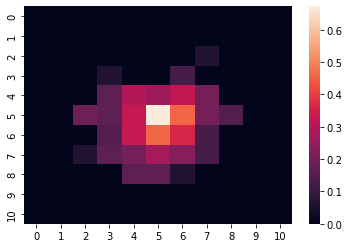

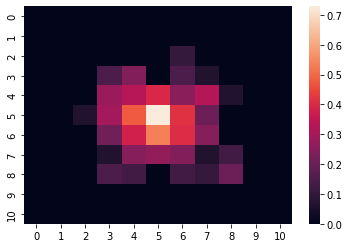

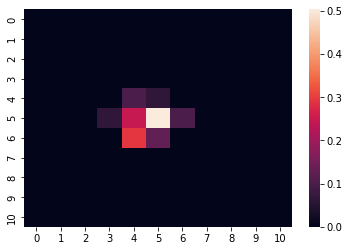

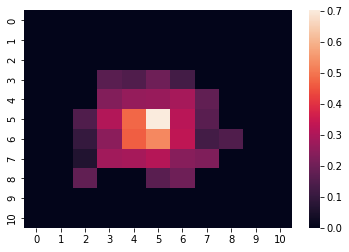

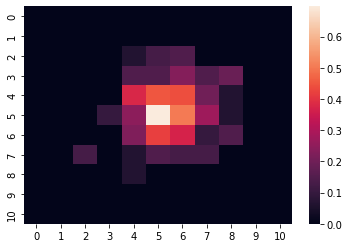

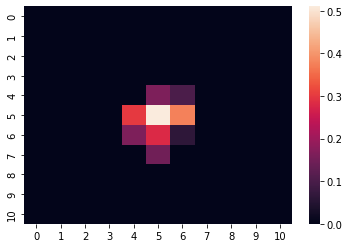

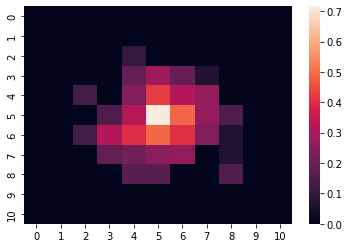

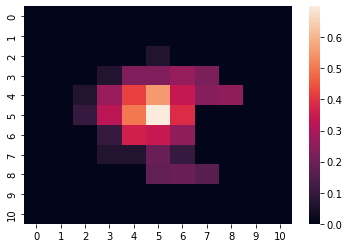

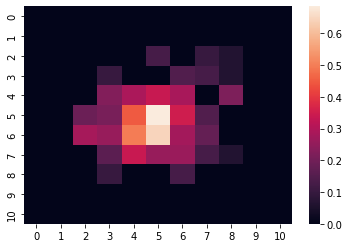

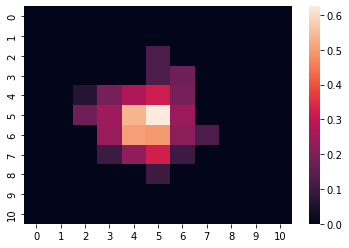

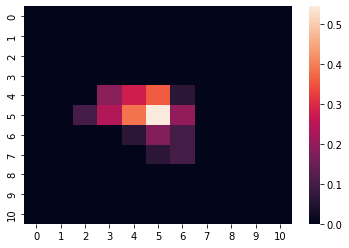

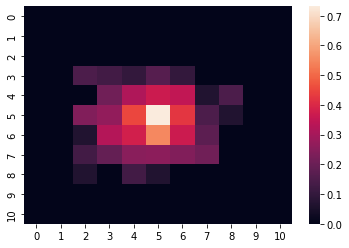

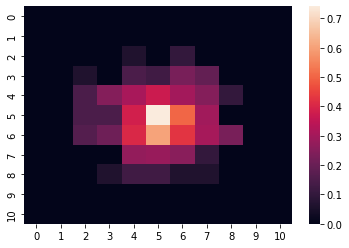

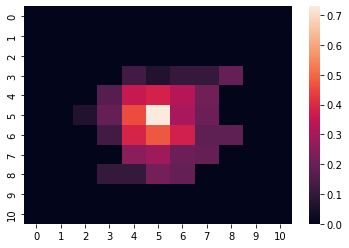

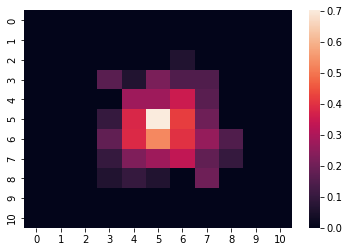

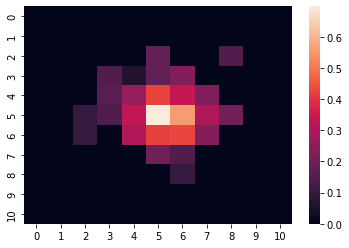

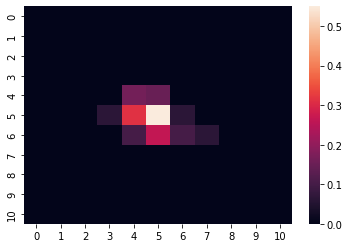

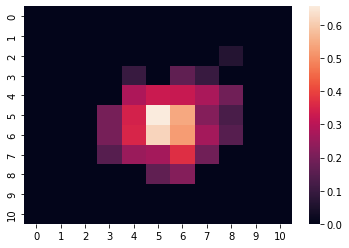

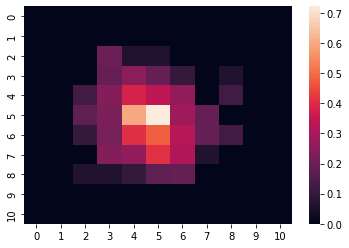

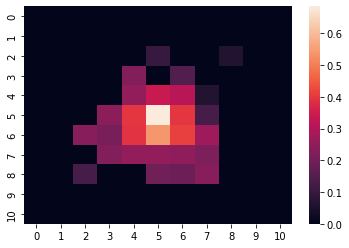

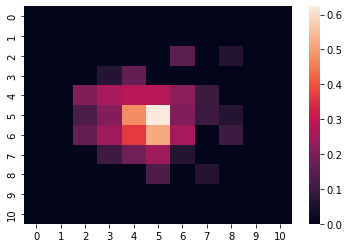

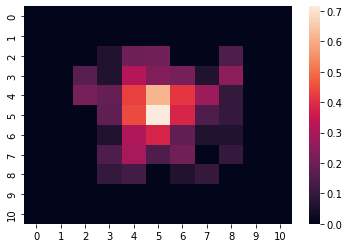

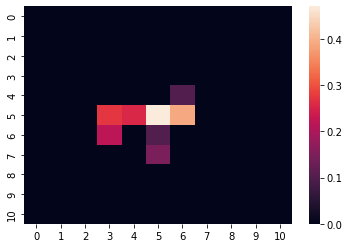

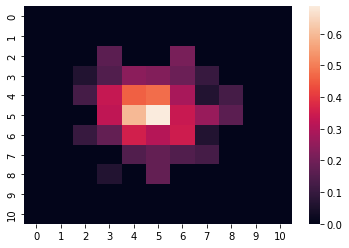

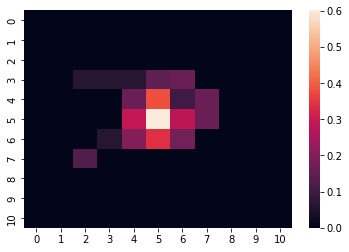

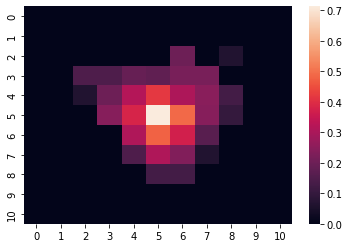

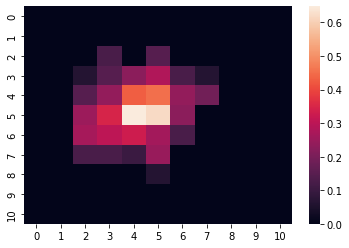

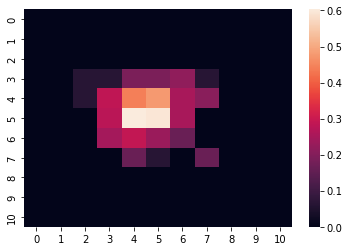

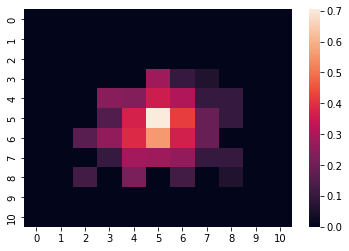

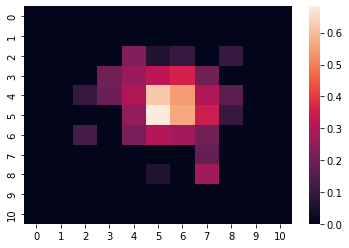

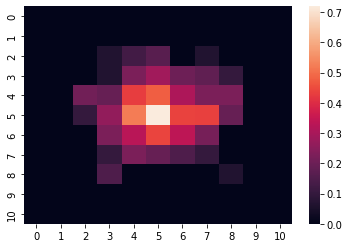

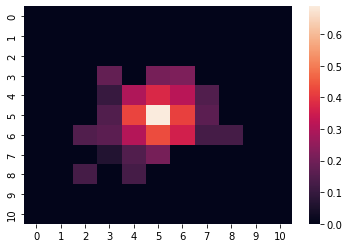

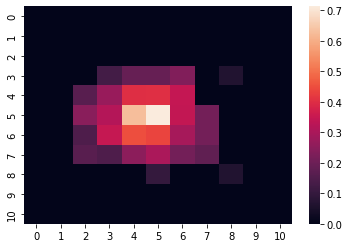

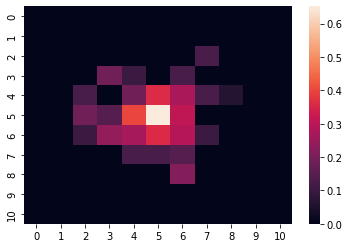

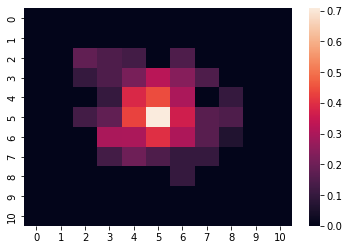

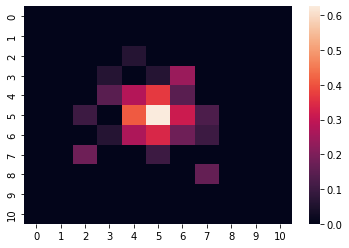

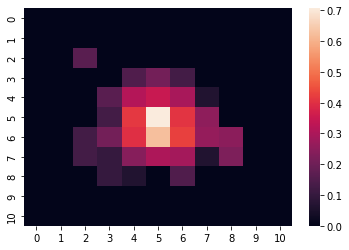

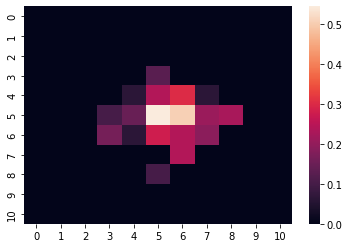

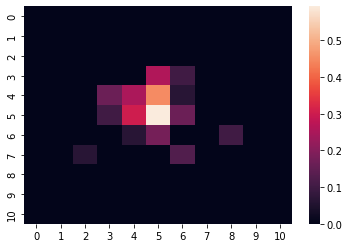

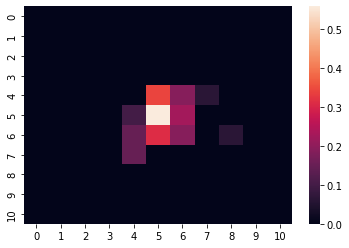

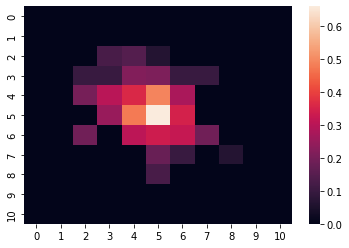

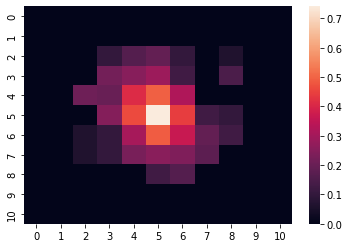

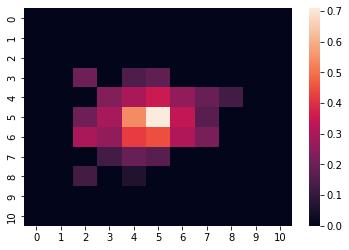

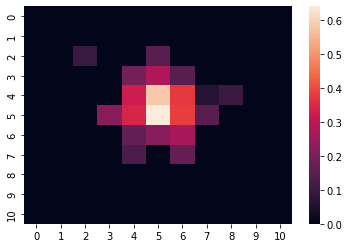

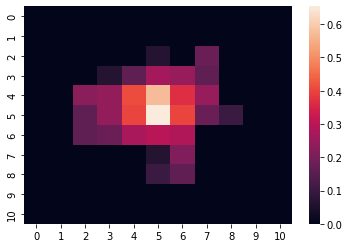

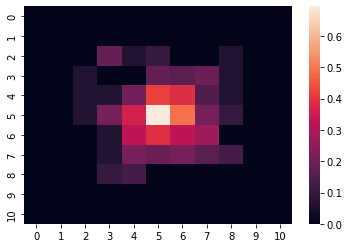

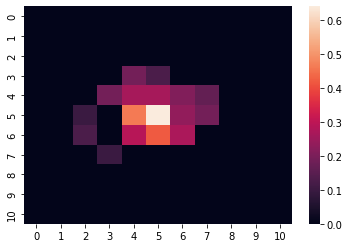

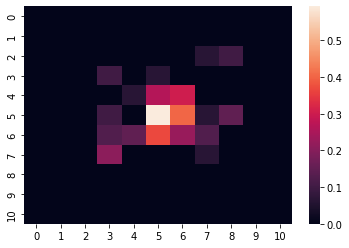

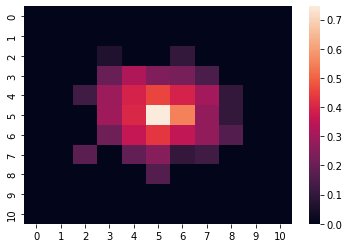

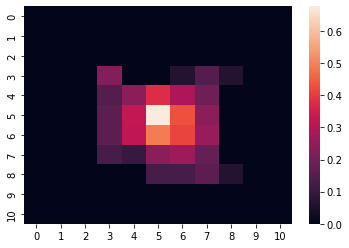

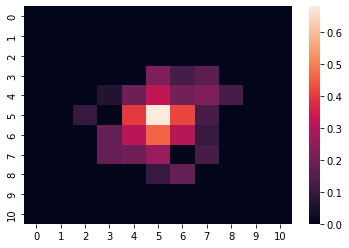

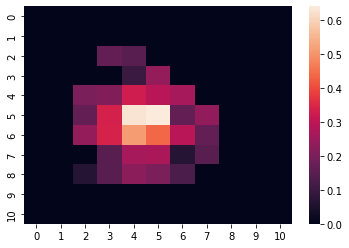

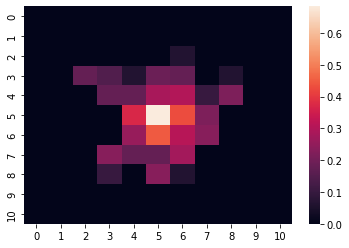

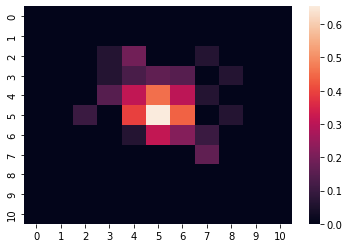

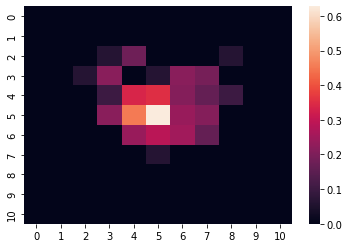

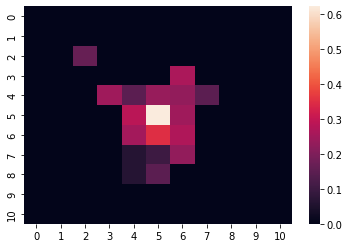

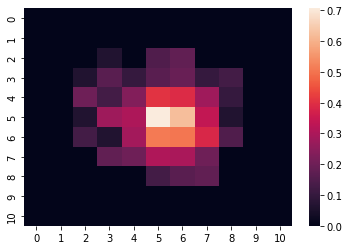

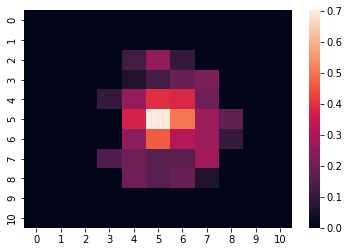

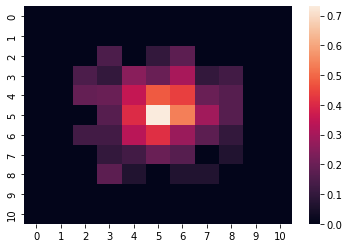

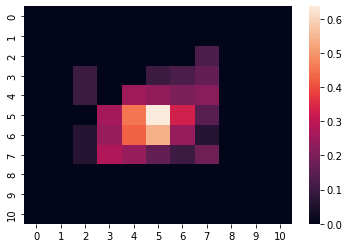

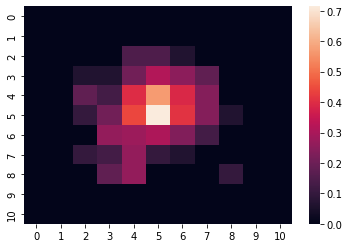

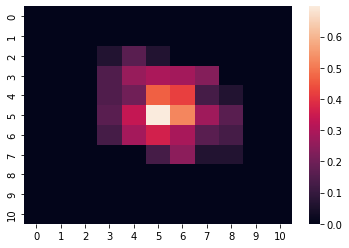

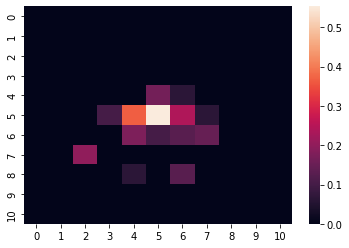

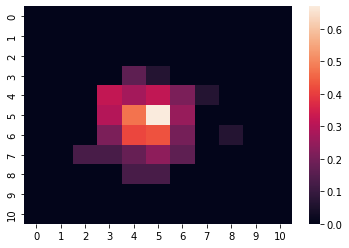

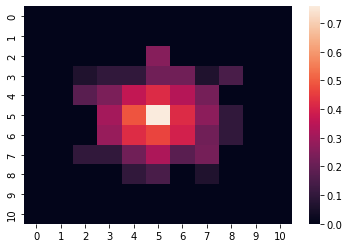

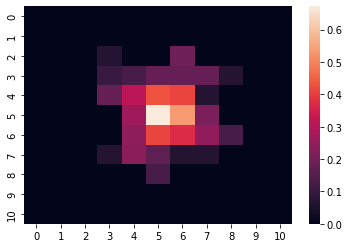

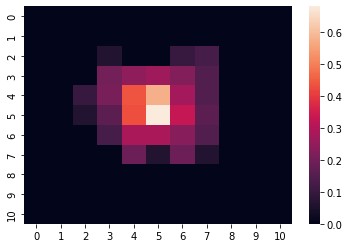

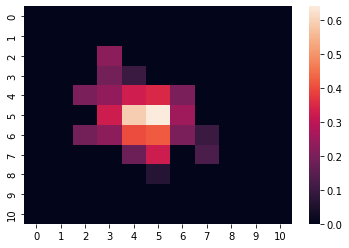

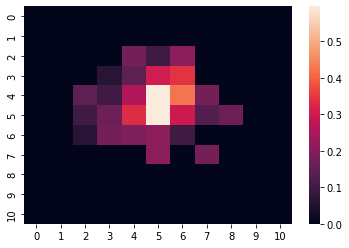

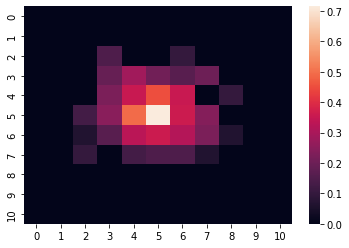

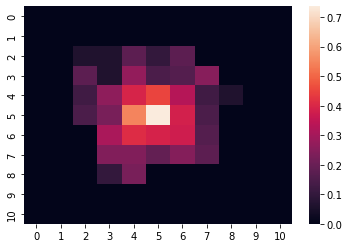

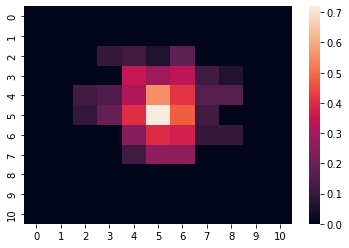

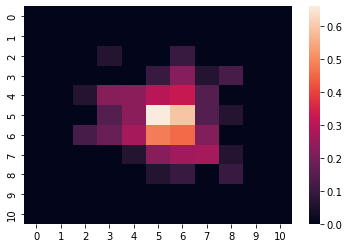

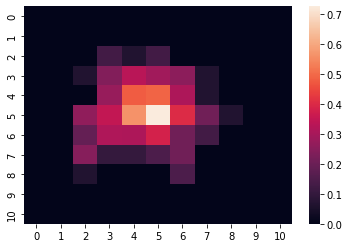

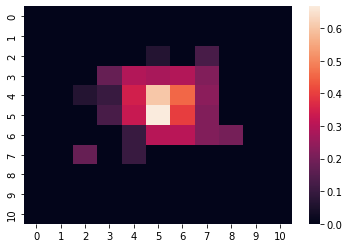

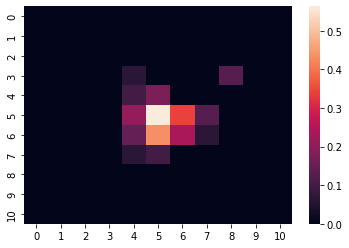

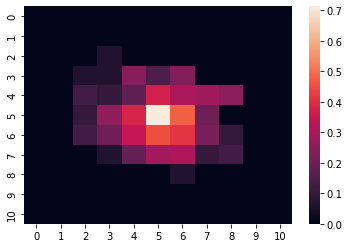

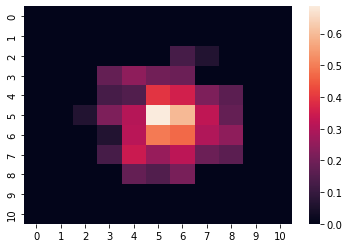

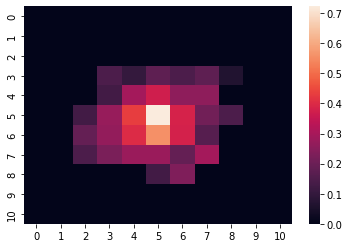

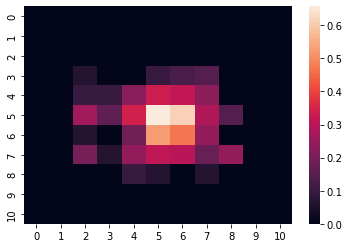

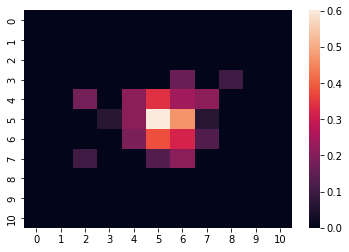

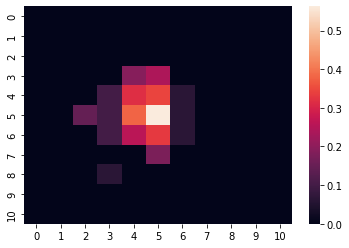

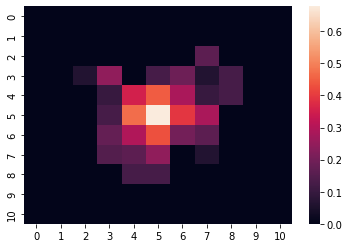

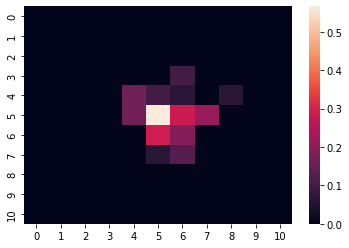

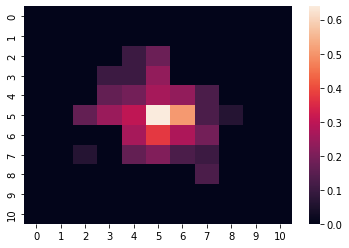

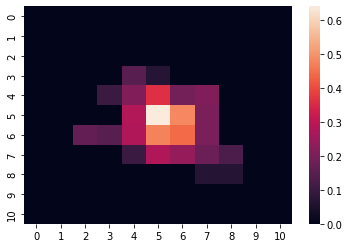

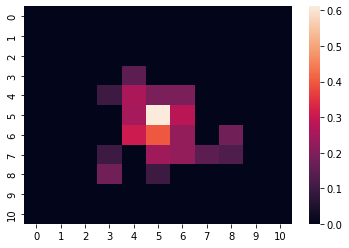

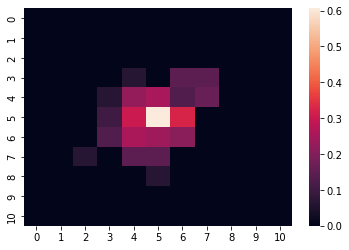

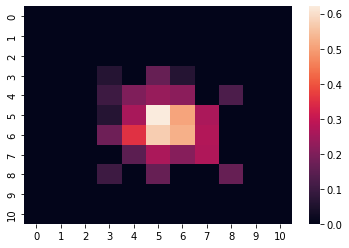

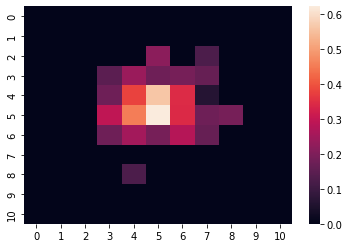

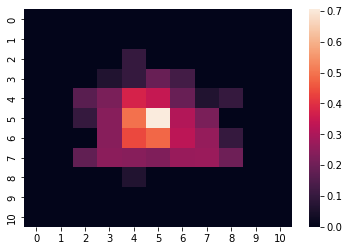

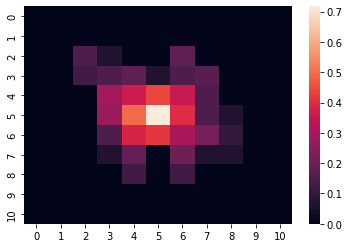

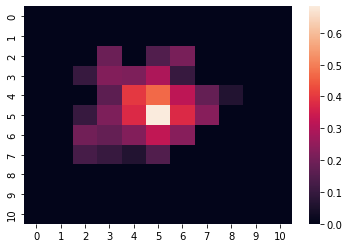

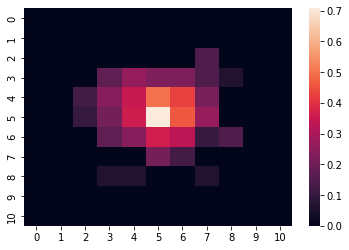

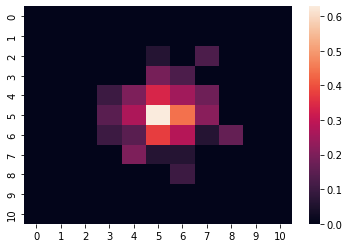

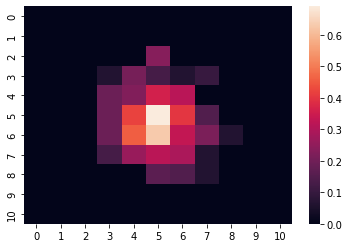

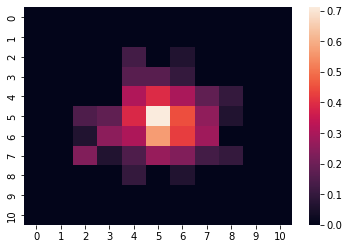

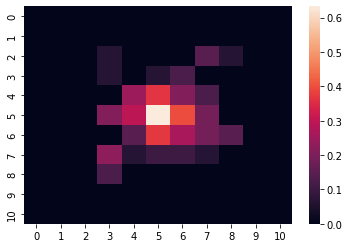

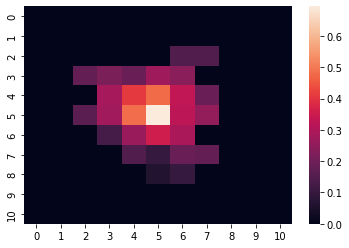

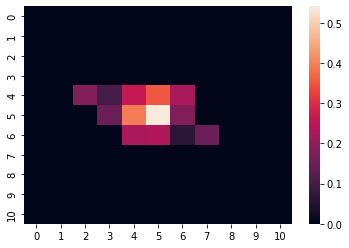

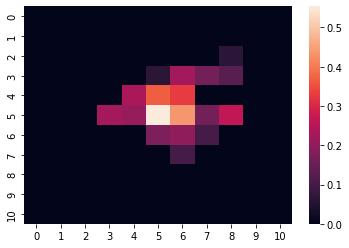

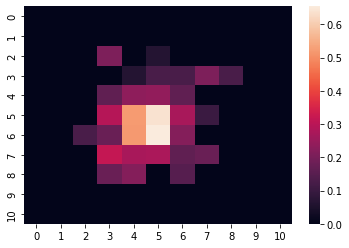

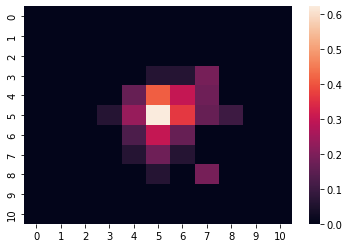

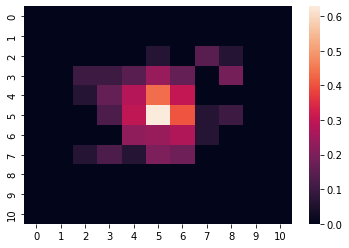

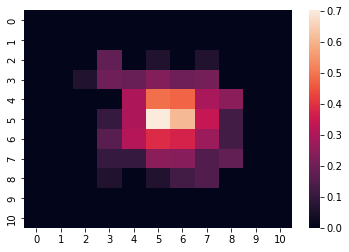

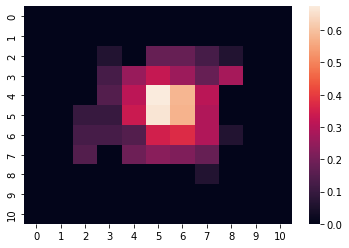

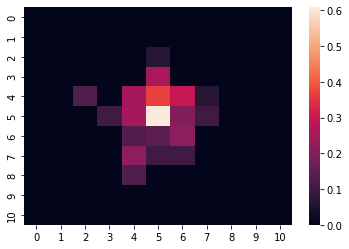

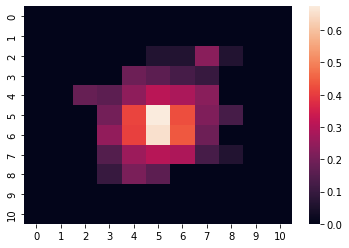

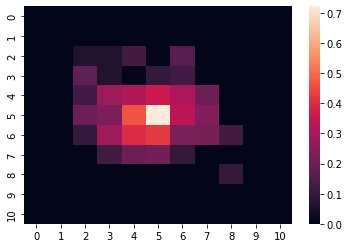

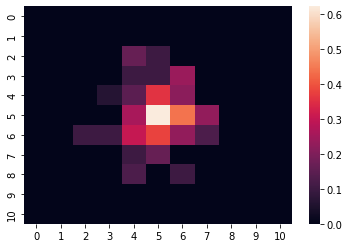

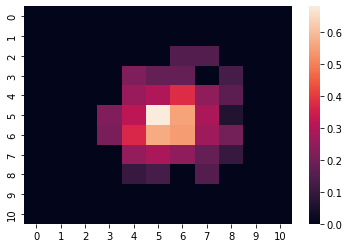

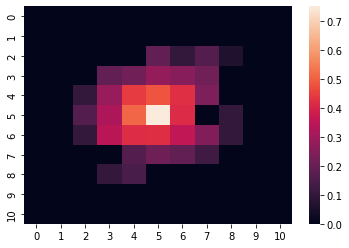

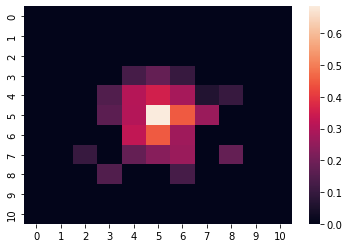

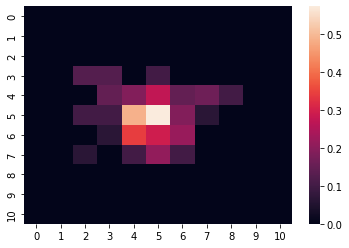

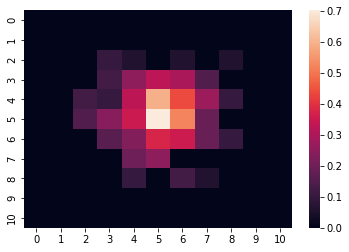

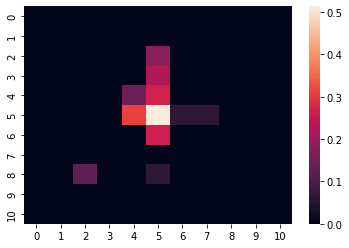

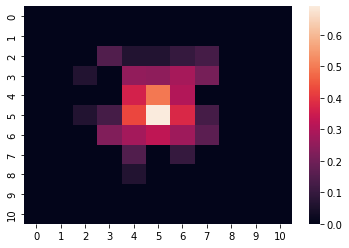

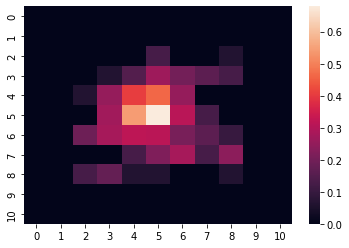

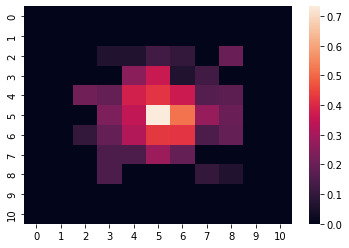

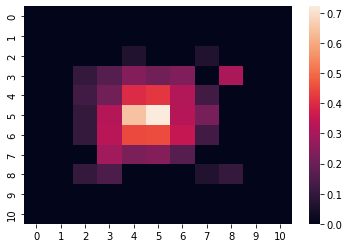

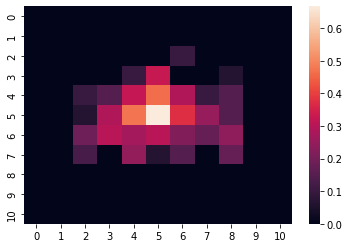

In [20]:
for i in range(res.shape[0]):
  arr = np.array(df.iloc[[i]])
  arr = np.reshape( arr, (11, 11))
  sn.heatmap(data = arr)
  name = "result_" + str(i) + ".png"
  plt.savefig(os.path.join("result_plots", name))
  plt.show()